# Tutorial: Two dimensional Poisson problem using Extra Features Learning

This tutorial presents how to solve with Physics-Informed Neural Networks (PINNs) a 2D Poisson problem with Dirichlet boundary conditions. We will train with standard PINN's training, and with extrafeatures. For more insights on extrafeature learning please read [*An extended physics informed neural network for preliminary analysis of parametric optimal control problems*](https://www.sciencedirect.com/science/article/abs/pii/S0898122123002018).

First of all, some useful imports.

In [1]:
import torch
from torch.nn import Softplus

from pina.problem import SpatialProblem
from pina.operators import laplacian
from pina.model import FeedForward
from pina.solvers import PINN
from pina.trainer import Trainer
from pina.plotter import Plotter
from pina.geometry import CartesianDomain
from pina.equation import Equation, FixedValue
from pina import Condition, LabelTensor
from pina.callbacks import MetricTracker

## The problem definition

The two-dimensional Poisson problem is mathematically written as:
\begin{equation}
\begin{cases}
\Delta u = \sin{(\pi x)} \sin{(\pi y)} \text{ in } D, \\
u = 0 \text{ on } \Gamma_1 \cup \Gamma_2 \cup \Gamma_3 \cup \Gamma_4,
\end{cases}
\end{equation}
where $D$ is a square domain $[0,1]^2$, and $\Gamma_i$, with $i=1,...,4$, are the boundaries of the square.

The Poisson problem is written in **PINA** code as a class. The equations are written as *conditions* that should be satisfied in the corresponding domains. The *truth_solution*
is the exact solution which will be compared with the predicted one.

In [2]:
class Poisson(SpatialProblem):
    output_variables = ['u']
    spatial_domain = CartesianDomain({'x': [0, 1], 'y': [0, 1]})

    def laplace_equation(input_, output_):
        force_term = (torch.sin(input_.extract(['x'])*torch.pi) *
                      torch.sin(input_.extract(['y'])*torch.pi))
        laplacian_u = laplacian(output_, input_, components=['u'], d=['x', 'y'])
        return laplacian_u - force_term

    # here we write the problem conditions
    conditions = {
        'gamma1': Condition(location=CartesianDomain({'x': [0, 1], 'y':  1}), equation=FixedValue(0.)),
        'gamma2': Condition(location=CartesianDomain({'x': [0, 1], 'y': 0}), equation=FixedValue(0.)),
        'gamma3': Condition(location=CartesianDomain({'x':  1, 'y': [0, 1]}), equation=FixedValue(0.)),
        'gamma4': Condition(location=CartesianDomain({'x': 0, 'y': [0, 1]}), equation=FixedValue(0.)),
        'D': Condition(location=CartesianDomain({'x': [0, 1], 'y': [0, 1]}), equation=Equation(laplace_equation)),
    }

    def poisson_sol(self, pts):
        return -(
            torch.sin(pts.extract(['x'])*torch.pi)*
            torch.sin(pts.extract(['y'])*torch.pi)
        )/(2*torch.pi**2)
    
    truth_solution = poisson_sol

problem = Poisson()

# let's discretise the domain
problem.discretise_domain(25, 'grid', locations=['D'])
problem.discretise_domain(25, 'grid', locations=['gamma1', 'gamma2', 'gamma3', 'gamma4'])

## Solving the problem with standard PINNs

After the problem, the feed-forward neural network is defined, through the class `FeedForward`. This neural network takes as input the coordinates (in this case $x$ and $y$) and provides the unkwown field of the Poisson problem. The residual of the equations are evaluated at several sampling points (which the user can manipulate using the method `CartesianDomain_pts`) and the loss minimized by the neural network is the sum of the residuals.

In this tutorial, the neural network is composed by two hidden layers of 10 neurons each, and it is trained for 1000 epochs with a learning rate of 0.006 and $l_2$ weight regularization set to $10^{-7}$. These parameters can be modified as desired. We use the `MetricTracker` class to track the metrics during training.

In [3]:
# make model + solver + trainer
model = FeedForward(
    layers=[10, 10],
    func=Softplus,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)
pinn = PINN(problem, model, optimizer_kwargs={'lr':0.006, 'weight_decay':1e-8})
trainer = Trainer(pinn, max_epochs=1000, callbacks=[MetricTracker()], accelerator='cpu', enable_model_summary=False) # we train on CPU and avoid model summary at beginning of training (optional)

# train
trainer.train()

/u/d/dcoscia/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/u/d/dcoscia/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:651: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /u/d/dcoscia/PINA/tutorials/tutorial2/lightning_logs


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Now the `Plotter` class is used to plot the results.
The solution predicted by the neural network is plotted on the left, the exact one is represented at the center and on the right the error between the exact and the predicted solutions is showed. 

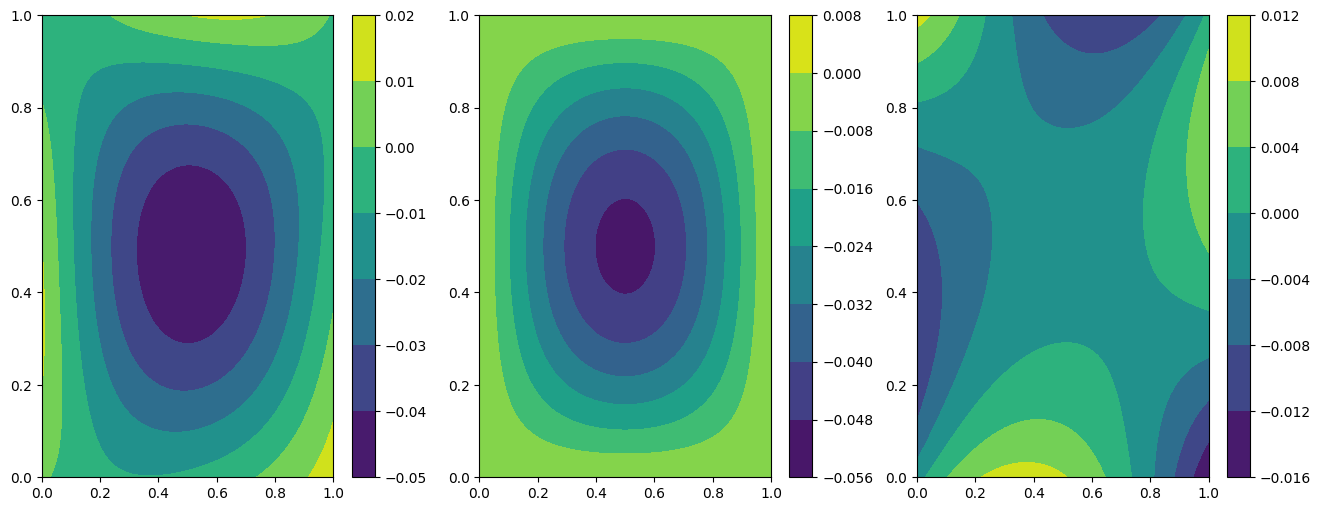

In [4]:
plotter = Plotter()
plotter.plot(trainer)

## Solving the problem with extra-features PINNs

Now, the same problem is solved in a different way.
A new neural network is now defined, with an additional input variable, named extra-feature, which coincides with the forcing term in the Laplace equation. 
The set of input variables to the neural network is:

\begin{equation}
[x, y, k(x, y)], \text{ with } k(x, y)=\sin{(\pi x)}\sin{(\pi y)},
\end{equation}

where $x$ and $y$ are the spatial coordinates and $k(x, y)$ is the added feature. 

This feature is initialized in the class `SinSin`, which needs to be inherited by the `torch.nn.Module` class and to have the `forward` method. After declaring such feature, we can just incorporate in the `FeedForward` class thanks to the `extra_features` argument.
**NB**: `extra_features` always needs a `list` as input, you you have one feature just encapsulated it in a class, as in the next cell.

Finally, we perform the same training as before: the problem is `Poisson`, the network is composed by the same number of neurons and optimizer parameters are equal to previous test, the only change is the new extra feature.

In [5]:
class SinSin(torch.nn.Module):
    """Feature: sin(x)*sin(y)"""
    def __init__(self):
        super().__init__()

    def forward(self, x):
        t = (torch.sin(x.extract(['x'])*torch.pi) *
             torch.sin(x.extract(['y'])*torch.pi))
        return LabelTensor(t, ['sin(x)sin(y)'])


# make model + solver + trainer
model_feat = FeedForward(
    layers=[10, 10],
    func=Softplus,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)+1
)
pinn_feat = PINN(problem, model_feat, extra_features=[SinSin()], optimizer_kwargs={'lr':0.006, 'weight_decay':1e-8})
trainer_feat = Trainer(pinn_feat, max_epochs=1000, callbacks=[MetricTracker()], accelerator='cpu', enable_model_summary=False) # we train on CPU and avoid model summary at beginning of training (optional)

# train
trainer_feat.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


The predicted and exact solutions and the error between them are represented below.
We can easily note that now our network, having almost the same condition as before, is able to reach additional order of magnitudes in accuracy.

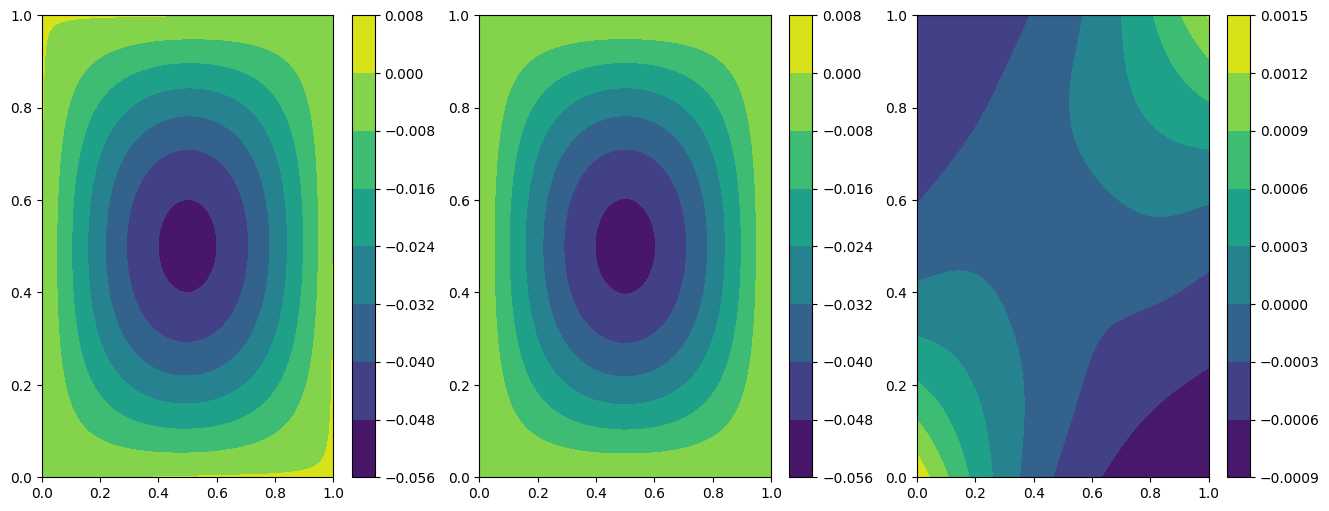

In [6]:
plotter.plot(trainer_feat)

## Solving the problem with learnable extra-features PINNs

We can still do better!

Another way to exploit the  extra features is the addition of learnable parameter inside them.
In this way, the added parameters are learned during the training phase of the neural network. In this case, we use:

\begin{equation}
k(x, \mathbf{y}) = \beta \sin{(\alpha x)} \sin{(\alpha y)},
\end{equation}

where $\alpha$ and $\beta$ are the abovementioned parameters.
Their implementation is quite trivial: by using the class `torch.nn.Parameter` we cam define all the learnable parameters we need, and they are managed by `autograd` module!

In [8]:
class SinSinAB(torch.nn.Module):
    """ """
    def __init__(self):
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.tensor([1.0]))
        self.beta = torch.nn.Parameter(torch.tensor([1.0]))


    def forward(self, x):
        t =  (
            self.beta*torch.sin(self.alpha*x.extract(['x'])*torch.pi)*
                      torch.sin(self.alpha*x.extract(['y'])*torch.pi)
        )
        return LabelTensor(t, ['b*sin(a*x)sin(a*y)'])


# make model + solver + trainer
model_lean= FeedForward(
    layers=[10, 10],
    func=Softplus,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)+1
)
pinn_lean = PINN(problem, model_lean, extra_features=[SinSinAB()], optimizer_kwargs={'lr':0.006, 'weight_decay':1e-8})
trainer_learn = Trainer(pinn_lean, max_epochs=1000, accelerator='cpu', enable_model_summary=False) # we train on CPU and avoid model summary at beginning of training (optional)

# train
trainer_learn.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Umh, the final loss is not appreciabily better than previous model (with static extra features), despite the usage of learnable parameters. This is mainly due to the over-parametrization of the network: there are many parameter to optimize during the training, and the model in unable to understand automatically that only the parameters of the extra feature (and not the weights/bias of the FFN) should be tuned in order to fit our problem. A longer training can be helpful, but in this case the faster way to reach machine precision for solving the Poisson problem is removing all the hidden layers in the `FeedForward`, keeping only the $\alpha$ and $\beta$ parameters of the extra feature.

In [11]:
# make model + solver + trainer
model_lean= FeedForward(
    layers=[],
    func=Softplus,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)+1
)
pinn_learn = PINN(problem, model_lean, extra_features=[SinSinAB()], optimizer_kwargs={'lr':0.006, 'weight_decay':1e-8})
trainer_learn = Trainer(pinn_learn, max_epochs=1000, callbacks=[MetricTracker()], accelerator='cpu', enable_model_summary=False) # we train on CPU and avoid model summary at beginning of training (optional)

# train
trainer_learn.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In such a way, the model is able to reach a very high accuracy!
Of course, this is a toy problem for understanding the usage of extra features: similar precision could be obtained if the extra features are very similar to the true solution. The analyzed Poisson problem shows a forcing term very close to the solution, resulting in a perfect problem to address with such an approach.

We conclude here by showing the graphical comparison of the unknown field and the loss trend for all the test cases presented here: the standard PINN, PINN with extra features, and PINN with learnable extra features.

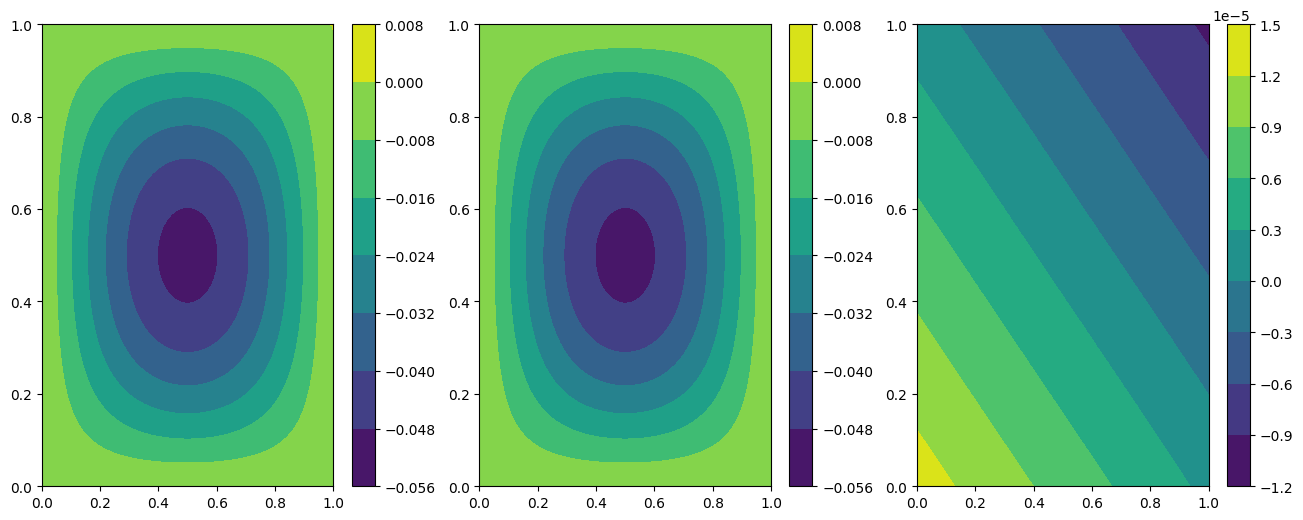

In [12]:
plotter.plot(trainer_learn)

Let us compare the training losses for the various types of training

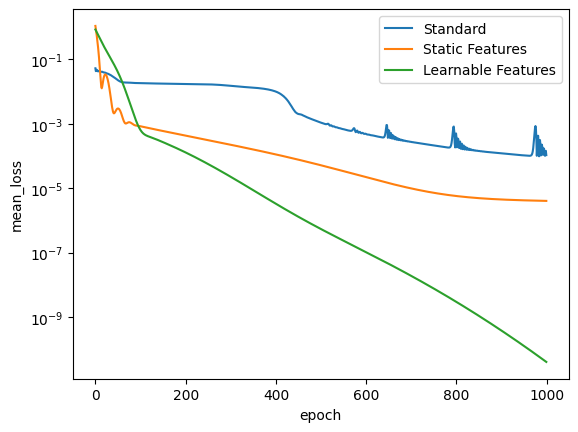

In [14]:
plotter.plot_loss(trainer, label='Standard')
plotter.plot_loss(trainer_feat, label='Static Features')
plotter.plot_loss(trainer_learn, label='Learnable Features')


## What's next?

Nice you have completed the two dimensional Poisson tutorial of **PINA**! There are multiple directions you can go now:

1. Train the network for longer or with different layer sizes and assert the finaly accuracy

2. Propose new types of extrafeatures and see how they affect the learning

3. Exploit extrafeature training in more complex problems

4. Many more...